# Investigating the step change in behaviour with lead time apparent in the forecasts in 2005

In [1]:
import glob

import dask

import cftime

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

In [91]:
cluster.close()
client.close()

In [2]:
from dask.distributed import Client
from dask_jobqueue import PBSCluster

walltime = "02:00:00"
cores = 48
memory = "192GB"
cluster = PBSCluster(
    walltime=str(walltime),
    cores=cores,
    memory=str(memory),
    job_extra=[
        "-l ncpus=" + str(cores),
        "-l mem=" + str(memory),
        "-P xv83",
        "-l jobfs=100GB",
        "-l storage=gdata/xv83",
    ],
    local_directory="$PBS_JOBFS",
    # env_extra=['export MALLOC_TRIM_THRESHOLD_="0"'],
    header_skip=["select"],
)

/g/data/xv83/users/ds0092/software/miniconda3/envs/pangeo/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
cluster.scale(jobs=1)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.6.63.33:8787/status,
Dashboard: http://10.6.63.33:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.63.33:42045,Workers: 0
Dashboard: http://10.6.63.33:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

### Load CAFE-f6 hindcasts

In [5]:
def open_mfzarr(files, preprocess=None, parallel=False, **open_kwargs):
    """Open multiple zarr files applying a preprocess step prior to merging

    NOTE: for some reason, using parallel=True produces cftime.datetime objects
    that break with DatatimeAccessor methods like dt.floor. Opening the data in
    serial does not, see https://github.com/pydata/xarray/issues/6026
    """
    open_zarr_ = dask.delayed(xr.open_zarr) if parallel else xr.open_zarr
    preprocess_ = dask.delayed(preprocess) if parallel else preprocess
    open_tasks = [open_zarr_(f, **open_kwargs) for f in files]
    preprocess_tasks = (
        [preprocess_(task) for task in open_tasks]
        if preprocess is not None
        else open_tasks
    )
    datasets = dask.compute(preprocess_tasks)[0] if parallel else preprocess_tasks
    return xr.combine_by_coords(
        datasets, compat="override", coords="minimal"
    ).unify_chunks()

In [15]:
def round_to_start_of_month(ds, dim):
    """Return provided array with specified time dimension rounded to the start of
    the month
    """
    from xarray.coding.cftime_offsets import MonthBegin

    return ds.assign_coords({dim: ds[dim].dt.floor("D") - MonthBegin()})


def convert_time_to_lead(ds, time_dim="time", init_dim="init", lead_dim="lead"):
    """Return provided array with time dimension converted to lead time dimension
    and time added as additional coordinate
    """
    init_date = ds[time_dim].time[0].item()
    lead_time = range(len(ds[time_dim]))
    time_coord = (
        ds[time_dim]
        .rename({time_dim: lead_dim})
        .assign_coords({lead_dim: lead_time})
        .expand_dims({init_dim: [init_date]})
    )
    dataset = ds.rename({time_dim: lead_dim}).assign_coords(
        {lead_dim: lead_time, init_dim: [init_date]}
    )
    dataset = dataset.assign_coords({time_dim: time_coord})
    return dataset


def coarsen_monthly_to_annual(ds, start_point=None, dim="time"):
    """Coarsen monthly data to annual, applying 'max' to all relevant coords and
    optionally starting at a particular point in the array
    """
    aux_coords = [c for c in ds.coords if dim in ds[c].dims]
    return (
        ds.sel({dim: slice(start_point, None)})
        .coarsen({dim: 12}, boundary="trim", coord_func={d: "max" for d in aux_coords})
        .mean()
    )


def truncate_latitudes(ds, dp=10):
    """Return provided array with latitudes truncated to specified dp.

    This is necessary due to precision differences from running forecasts on
    different systems
    """
    for dim in ds.dims:
        if "lat" in dim:
            ds = ds.assign_coords({dim: ds[dim].round(decimals=dp)})
    return ds


def preprocess_CAFEf6_monthly_to_annual(ds):
    """Preprocessing steps for CAFE-f6 data"""

    ds = round_to_start_of_month(ds, dim="time")
    ds = convert_time_to_lead(ds)

    # Convert to annual data
    ds = coarsen_monthly_to_annual(ds, dim="lead")

    # Truncate lats so that forecasts run on different systems can be stacked
    ds = truncate_latitudes(ds)

    # Required by climpred
    ds = ds.rename({"ensemble": "member"})
    ds["lead"].attrs["units"] = "months"
    return ds

In [7]:
data_dir = "/g/data/xv83/dcfp/CAFE-f6"
realm = "atmos_isobaric_month.zarr.zip"

files = sorted(glob.glob(f"{data_dir}/c5-d60-pX-f6-*/{realm}"))

In [8]:
cafe_hcst = open_mfzarr(
    files, preprocess=preprocess_CAFEf6_monthly_to_annual, parallel=False
)["t_surf"]

# cafe_hcst = cafe_hcst.drop("time")  # Req by climpred

HCST_CHUNKS = {"init": -1, "lead": 1}
cafe_hcst = cafe_hcst.chunk(HCST_CHUNKS).persist()

/g/data/xv83/users/ds0092/software/miniconda3/envs/pangeo/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/g/data/xv83/users/ds0092/software/miniconda3/envs/pangeo/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/g/data/xv83/users/ds0092/software/miniconda3/envs/pangeo/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/g/data/xv83/users/ds0092/software/miniconda3/envs/pangeo/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/g/data/xv83/users/ds0092/software/miniconda3/envs/pangeo/lib/python3.9/site-packages/nu

# Plot strange behaviour in forecasts

In [17]:
hcst_gbl = cafe_hcst.weighted(cafe_hcst["area"]).mean(["lat", "lon", "member"])

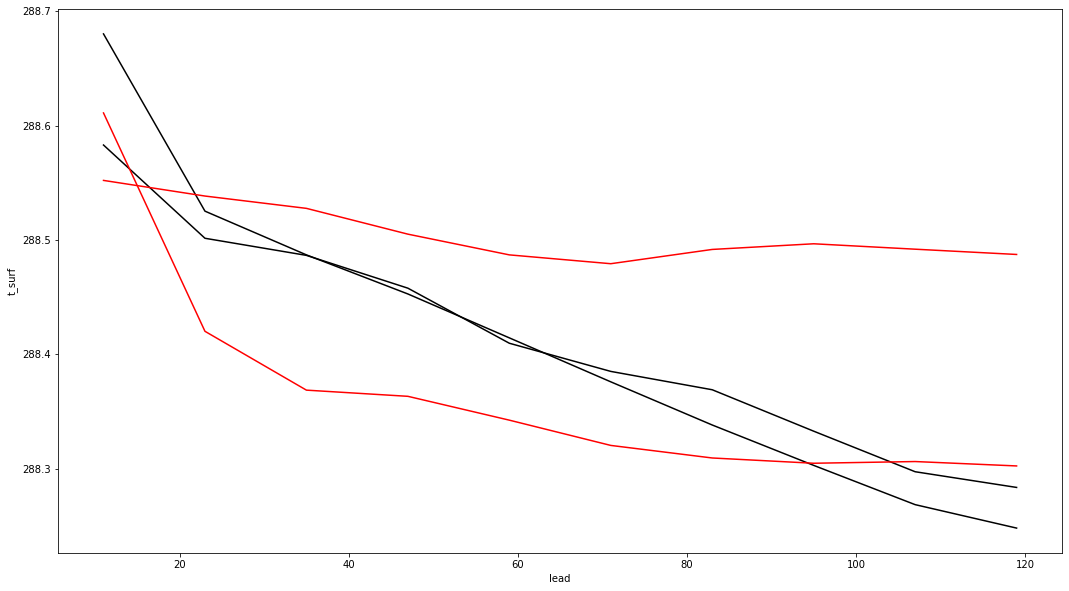

In [18]:
fig = plt.figure(figsize=(18, 10))

PERIOD_1 = slice("1995", "2004")
PERIOD_2 = slice("2005", "2014")

hcst_gbl.sel(init=PERIOD_1).groupby("init.month").mean("init").plot.line(
    x="lead", add_legend=False, color="k"
)

hcst_gbl.sel(init=PERIOD_2).groupby("init.month").mean("init").plot.line(
    x="lead", add_legend=False, color="r"
)

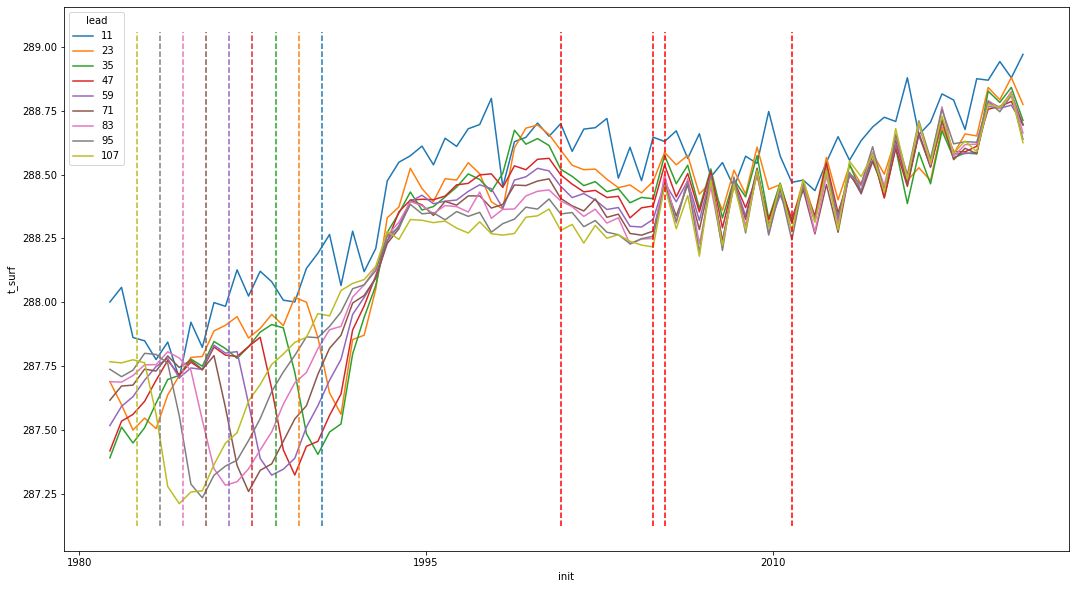

In [19]:
lead = range(11, 119, 12)

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18, 10))
hcst_gbl.sel(lead=lead).plot.line(x="init", add_legend=True)
ylim = plt.gca().get_ylim()
# plt.plot(
#     [cftime.DatetimeJulian(2005, 1, 1), cftime.DatetimeJulian(2005, 1, 1)],
#     ylim,
#     color="k",
#     linestyle="--",
# )

dates = [
    cftime.DatetimeJulian(2000, 11, 1),
    cftime.DatetimeJulian(2004, 11, 1),
    cftime.DatetimeJulian(2005, 5, 1),
    cftime.DatetimeJulian(2010, 11, 1),
]

for date in dates:
    plt.plot(
        [date, date],
        ylim,
        color="r",
        linestyle="--",
    )


for c, l in enumerate(lead):
    plt.plot(
        xr.CFTimeIndex(
            [cftime.DatetimeJulian(1991, 6, 1), cftime.DatetimeJulian(1991, 6, 1)]
        ).shift(-l, freq="MS"),
        ylim,
        color=f"C{c}",
        linestyle="--",
    )

# How does the namelist change across this period?

In [88]:
!diff ../resources/c5-d60-pX-f6-20041101-base.MOM.input.nml ../resources/c5-d60-pX-f6-20050501-base.MOM.input.nml

962,963c962,963
<     basic_ozone_type = 'time_varying'
<     !ozone_dataset_entry=2014, 1, 1, 0, 0, 0,
---
>     basic_ozone_type = 'fixed_year'
>     ozone_dataset_entry=2014, 1, 1, 0, 0, 0,
965c965
<     filename = CM3_CMIP6_1950-2014_O3.nc
---
>     filename = cm3_2014_o3.padded.nc


# This is the point at which we change from time varying ozone forcing (with lead using `CM3_CMIP6_1950-2014_O3.nc`) to fixed year (2014 using `cm3_2014_o3.padded.nc`) forcing

In [38]:
ozone_pre = xr.open_dataset(
    "../resources/c5-d60-pX-f6-20101101-base.MOM.INPUT.CM3_CMIP6_1950-2014_O3.nc"
)["ozone"]

ozone_post = xr.open_dataset(
    "../resources/c5-d60-pX-f6-20101101-base.MOM.INPUT.cm3_2014_o3.padded.nc"
)["ozone"]

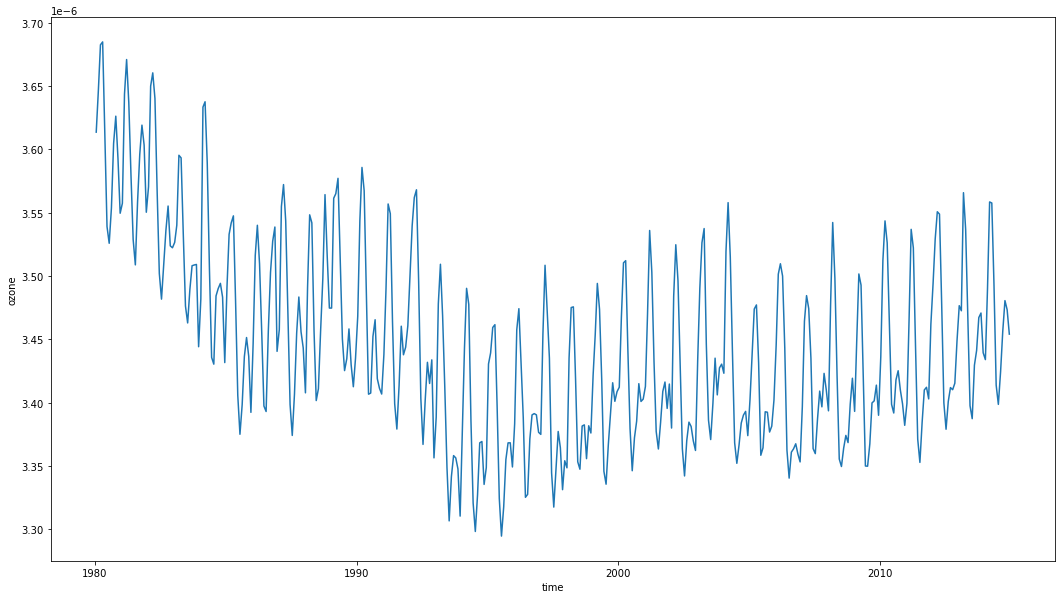

In [57]:
fig = plt.figure(figsize=(18, 10))
ozone_pre.sel(time=slice("1980", None)).mean(["lat", "lon", "pfull"]).plot()

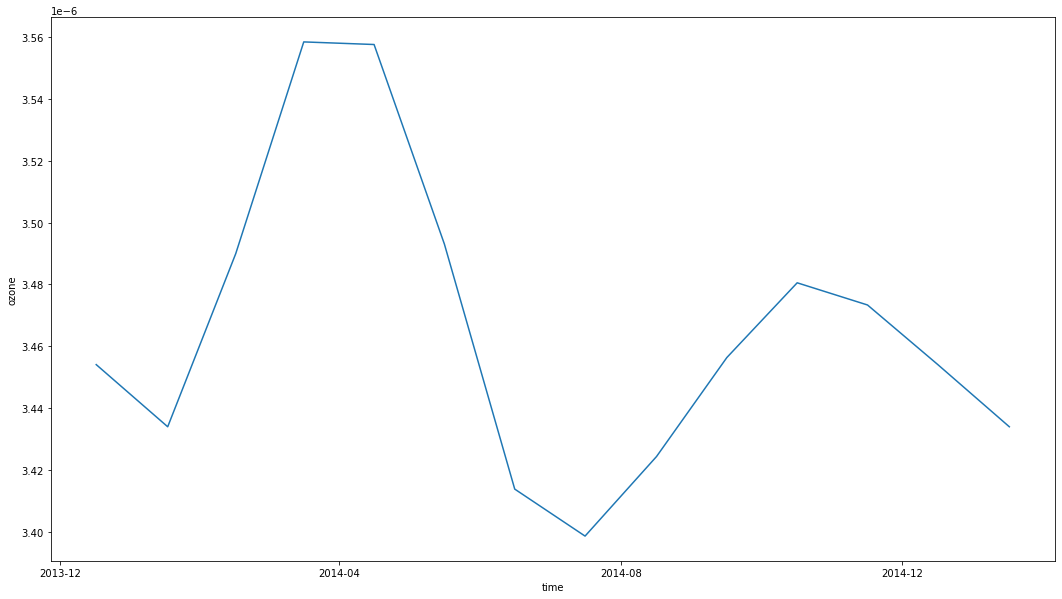

In [58]:
fig = plt.figure(figsize=(18, 10))
ozone_post.mean(["lat", "lon", "pfull"]).plot()

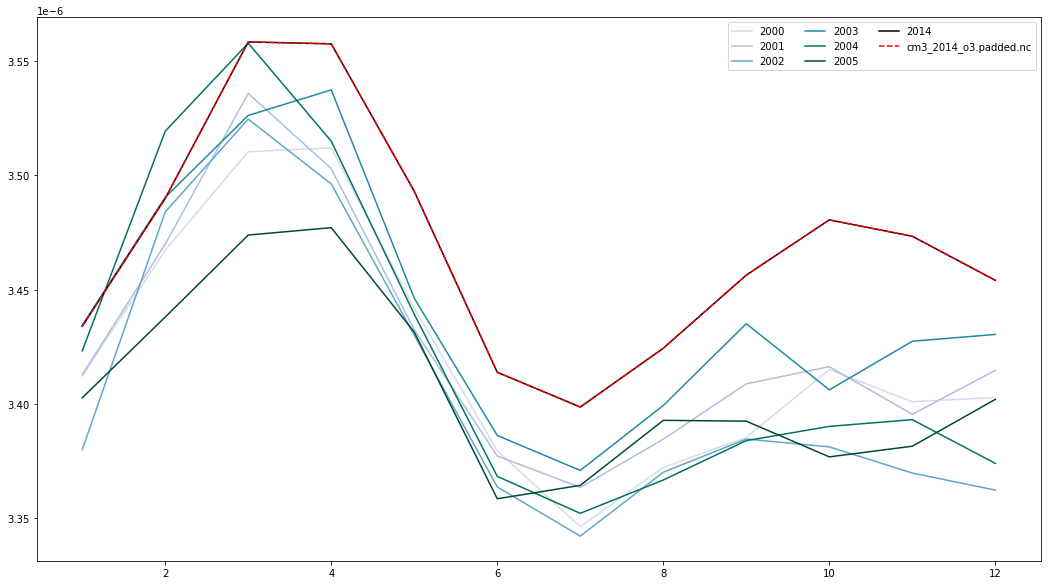

In [87]:
fig = plt.figure(figsize=(18, 10))
from matplotlib.pyplot import cm

level = slice(0, None)  # [10]

gbl_pre = ozone_pre.isel(pfull=level).mean(["lat", "lon", "pfull"])
years = range(2000, 2006)
colors = cm.PuBuGn(np.linspace(0.2, 1, len(years)))
for year, c in zip(years, colors):
    gbl = gbl_pre.sel(time=str(year))
    plt.plot(range(1, 13), gbl, label=str(year), color=c)
plt.plot(range(1, 13), gbl_pre.sel(time="2014"), label="2014", color="k")

gbl_post = ozone_post.isel(pfull=level).mean(["lat", "lon", "pfull"])
plt.plot(
    range(1, 13),
    gbl_post.sel(time="2014"),
    label="cm3_2014_o3.padded.nc",
    color="r",
    linestyle="--",
)

plt.legend(ncol=3)

# What do the historical data do?

In [20]:
data_dir = "/g/data/xv83/users/ds0092/data/CAFE/historical/WIP"
realm = "atmos_isobaric_month.zarr.zip"

In [21]:
cafe_hist = truncate_latitudes(
    xr.open_zarr(f"{data_dir}/c5-d60-pX-hist-19601101/ZARR/{realm}")
)["t_surf"]

cafe_hist = cafe_hist.rename({"ensemble": "member"})  # Req by climpred

cafe_hist = round_to_start_of_month(cafe_hist, dim="time")

# Process annual means to match hcst dataset
cafe_hist = xr.concat(
    [
        coarsen_monthly_to_annual(cafe_hist, cafe_hcst.init[0]),
        coarsen_monthly_to_annual(cafe_hist, cafe_hcst.init[1]),
    ],
    dim="time",
).sortby("time")

/g/data/xv83/users/ds0092/software/miniconda3/envs/pangeo/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing with an out-of-order index is generating 59 times more chunks
  return self.array[key]
/g/data/xv83/users/ds0092/software/miniconda3/envs/pangeo/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing with an out-of-order index is generating 59 times more chunks
  return self.array[key]
/g/data/xv83/users/ds0092/software/miniconda3/envs/pangeo/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing with an out-of-order index is generating 59 times more chunks
  return self.array[key]


In [23]:
hist_gbl = cafe_hist.weighted(cafe_hist["area"]).mean(["lat", "lon", "member"])

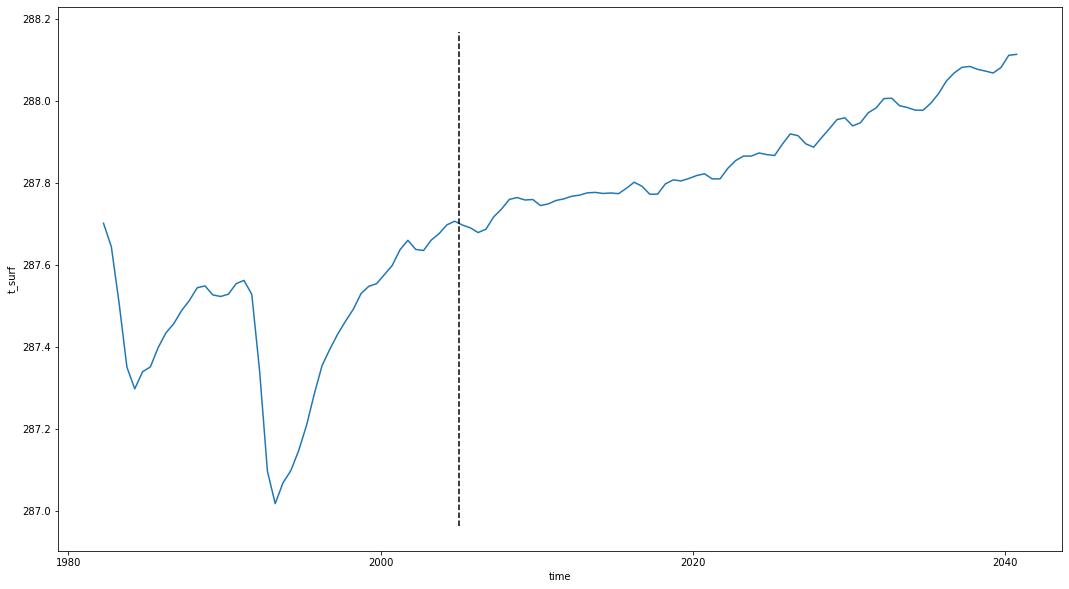

In [27]:
fig = plt.figure(figsize=(18, 10))

hist_gbl.plot()

ylim = plt.gca().get_ylim()
plt.plot(
    [cftime.DatetimeJulian(2005, 1, 1), cftime.DatetimeJulian(2005, 1, 1)],
    ylim,
    color="k",
    linestyle="--",
)